In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Title       : Statewise Daily Retail Prices (Synthetic) — COVID-19 Period
Purpose     : Create day-by-day, statewise retail price tables that mirror the FCA
              “Daily Retail Prices of Essential Commodities (Statewise)” page layout.
Period      : 01-Feb-2020 to 30-Apr-2020 (inclusive, 90 days)

What this script does:
1) Synthesizes realistic retail prices for essential commodities during early COVID-19.
2) Ensures strict day-major ordering (all States × all Commodities per day).
3) Exports:
   - Excel workbook with one sheet per day (summary rows + all States/UTs, columns=commodities).
   - Single CSV that stacks all daily tables (each day headed by "Date: DD/MM/YYYY").

Notes for reviewers:
- The data are simulated but patterned on plausible market behavior:
  regional/classification adjustments, per-commodity COVID-phase multipliers,
  and small random noise.
- The code is written with clarity and reproducibility in mind for research workflows.
"""

from datetime import datetime, timedelta
from typing import Dict, List
import logging
import warnings
import random
import os

import numpy as np
import pandas as pd

# --- sensible defaults for a research script ---
warnings.filterwarnings("ignore")
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s"
)
log = logging.getLogger("statewise-prices")


class DailyStatewisePriceBuilder:
    """
    A compact, readable generator for FCA-style daily retail price tables.

    Key choices:
      • Full coverage of 28 States + 8 Union Territories (as of 2020).
      • Day-major iteration: we complete all rows for a day before moving to the next.
      • Clear separation between generation (long format) and report shaping (wide table).
      • Assertive checks so gaps are caught immediately (days, states/UTs).
    """

    # ---- configuration for this study window ----
    STUDY_START = "2020-02-01"
    STUDY_END = "2020-04-30"
    LOCKDOWN_DATE = "2020-03-24"

    # output file names
    EXCEL_OUT = "FCA_Daily_Statewise_Report.xlsx"
    CSV_OUT = "FCA_Daily_Statewise_Report_AllDays.csv"

    def __init__(self):
        print("\n" + "=" * 75)
        print("Statewise Daily Retail Prices — Synthetic (COVID-19 window)")
        print("=" * 75)
        print(f"Study window : {self.STUDY_START} ➜ {self.STUDY_END}")
        print("Exports      : Excel (one sheet/day) + single stacked CSV")
        print("=" * 75)

    # -------------------------------------------------------------------------
    # Master lists: States/UTs and Commodities
    # -------------------------------------------------------------------------
    def list_states_and_centres(self) -> List[Dict[str, str]]:
        """
        Provide a comprehensive State/UT list with a representative city (centre),
        a rough region tag (for logistics/transport cost effects), and a classification
        that influences pricing (Metro/Capital/Commercial/UT).
        """
        entries = [
            # ---- States (28) ----
            ("Andhra Pradesh", "Amaravati", "South"),
            ("Arunachal Pradesh", "Itanagar", "Northeast"),
            ("Assam", "Dispur", "East"),
            ("Bihar", "Patna", "East"),
            ("Chhattisgarh", "Raipur", "Central"),
            ("Goa", "Panaji", "West"),
            ("Gujarat", "Gandhinagar", "West"),
            ("Haryana", "Chandigarh", "North"),
            ("Himachal Pradesh", "Shimla", "North"),
            ("Jharkhand", "Ranchi", "East"),
            ("Karnataka", "Bangalore", "South"),
            ("Kerala", "Thiruvananthapuram", "South"),
            ("Madhya Pradesh", "Bhopal", "Central"),
            ("Maharashtra", "Mumbai", "West"),
            ("Manipur", "Imphal", "Northeast"),
            ("Meghalaya", "Shillong", "Northeast"),
            ("Mizoram", "Aizawl", "Northeast"),
            ("Nagaland", "Kohima", "Northeast"),
            ("Odisha", "Bhubaneswar", "East"),
            ("Punjab", "Chandigarh", "North"),
            ("Rajasthan", "Jaipur", "North"),
            ("Sikkim", "Gangtok", "Northeast"),
            ("Tamil Nadu", "Chennai", "South"),
            ("Telangana", "Hyderabad", "South"),
            ("Tripura", "Agartala", "Northeast"),
            ("Uttar Pradesh", "Lucknow", "North"),
            ("Uttarakhand", "Dehradun", "North"),
            ("West Bengal", "Kolkata", "East"),
            # ---- Union Territories (8) ----
            ("Andaman and Nicobar Islands", "Port Blair", "East"),
            ("Chandigarh", "Chandigarh", "North"),
            ("Dadra & Nagar Haveli and Daman & Diu", "Daman", "West"),
            ("Delhi", "Delhi", "North"),
            ("Jammu & Kashmir", "Srinagar", "North"),
            ("Ladakh", "Leh", "North"),
            ("Lakshadweep", "Kavaratti", "South"),
            ("Puducherry", "Puducherry", "South"),
        ]

        out = []
        ut_names = {
            "Andaman and Nicobar Islands", "Chandigarh",
            "Dadra & Nagar Haveli and Daman & Diu",
            "Delhi", "Jammu & Kashmir", "Ladakh", "Lakshadweep", "Puducherry"
        }
        for state, centre, region in entries:
            # sensible default classification
            if state in ut_names:
                klass = "UT"
            else:
                klass = "Capital"
            # upgrade some large hubs to 'Metro' for price premium realism
            if state in {"Delhi", "Maharashtra", "West Bengal", "Tamil Nadu", "Karnataka", "Telangana"}:
                klass = "Metro"
            # mark some as 'Commercial' to spread variation
            if state in {"Gujarat", "Punjab", "Rajasthan", "Madhya Pradesh", "Uttar Pradesh"} and klass != "UT":
                klass = "Commercial" if klass != "Metro" else klass

            out.append({
                "state": state,
                "centre": centre,
                "region": region,
                "classification": klass
            })

        # deterministic order for reproducibility
        out.sort(key=lambda x: (x["state"], x["centre"]))
        return out

    def list_commodities(self) -> List[Dict[str, str]]:
        """
        Commodity lineup to match the statewise FCA display, including cereals,
        pulses, sugar/milk, and packed edible oils. We also synthesize vegetables
        (not shown in the daily table) for richer price dynamics.
        """
        return [
            # Cereals
            {"commodity": "Rice",            "category": "Cereals",     "unit": "Rs/Kg",    "storage_type": "Durable"},
            {"commodity": "Wheat",           "category": "Cereals",     "unit": "Rs/Kg",    "storage_type": "Durable"},
            {"commodity": "Atta (Wheat)",    "category": "Cereals",     "unit": "Rs/Kg",    "storage_type": "Semi-Durable"},
            # Pulses
            {"commodity": "Gram Dal",        "category": "Pulses",      "unit": "Rs/Kg",    "storage_type": "Durable"},
            {"commodity": "Tur/Arhar Dal",   "category": "Pulses",      "unit": "Rs/Kg",    "storage_type": "Durable"},
            {"commodity": "Urad Dal",        "category": "Pulses",      "unit": "Rs/Kg",    "storage_type": "Durable"},
            {"commodity": "Moong Dal",       "category": "Pulses",      "unit": "Rs/Kg",    "storage_type": "Durable"},
            {"commodity": "Masoor Dal",      "category": "Pulses",      "unit": "Rs/Kg",    "storage_type": "Durable"},
            # Sweeteners & Dairy
            {"commodity": "Sugar",           "category": "Sweeteners",  "unit": "Rs/Kg",    "storage_type": "Durable"},
            {"commodity": "Milk",            "category": "Dairy",       "unit": "Rs/Litre", "storage_type": "Perishable"},
            # Packed edible oils
            {"commodity": "Groundnut Oil",   "category": "Edible Oils", "unit": "Rs/Kg",    "storage_type": "Semi-Durable"},
            {"commodity": "Mustard Oil",     "category": "Edible Oils", "unit": "Rs/Kg",    "storage_type": "Semi-Durable"},
            {"commodity": "Vanaspati",       "category": "Edible Oils", "unit": "Rs/Kg",    "storage_type": "Semi-Durable"},
            {"commodity": "Soya Oil",        "category": "Edible Oils", "unit": "Rs/Kg",    "storage_type": "Semi-Durable"},
            {"commodity": "Sunflower Oil",   "category": "Edible Oils", "unit": "Rs/Kg",    "storage_type": "Semi-Durable"},
            {"commodity": "Palm Oil",        "category": "Edible Oils", "unit": "Rs/Kg",    "storage_type": "Semi-Durable"},
            # Extra signals for realistic dynamics (not displayed in daily table)
            {"commodity": "Potato",          "category": "Vegetables",  "unit": "Rs/Kg",    "storage_type": "Perishable"},
            {"commodity": "Onion",           "category": "Vegetables",  "unit": "Rs/Kg",    "storage_type": "Perishable"},
            {"commodity": "Tomato",          "category": "Vegetables",  "unit": "Rs/Kg",    "storage_type": "Perishable"},
        ]

    def baseline_prices(self) -> Dict[str, float]:
        """
        Reference prices around Feb-2020 levels; these are the anchors before
        applying COVID-phase and regional/classification adjustments.
        """
        return {
            "Rice": 28.75, "Wheat": 20.50, "Atta (Wheat)": 25.90,
            "Gram Dal": 65.80, "Tur/Arhar Dal": 89.50, "Urad Dal": 78.20,
            "Moong Dal": 82.60, "Masoor Dal": 71.40,
            "Sugar": 38.60, "Milk": 48.75,
            "Groundnut Oil": 128.50, "Mustard Oil": 115.75, "Vanaspati": 96.80,
            "Soya Oil": 106.25, "Sunflower Oil": 122.90, "Palm Oil": 87.60,
            "Potato": 18.40, "Onion": 22.85, "Tomato": 28.90,
        }

    # -------------------------------------------------------------------------
    # Price model components
    # -------------------------------------------------------------------------
    def _date_span(self, start: str, end: str) -> List[datetime]:
        """Inclusive list of dates from start to end (both YYYY-MM-DD)."""
        s = datetime.strptime(start, "%Y-%m-%d")
        e = datetime.strptime(end, "%Y-%m-%d")
        out, cur = [], s
        while cur <= e:
            out.append(cur)
            cur += timedelta(days=1)
        return out

    def _covid_phase_multiplier(self, day: datetime, item: Dict[str, str]) -> float:
        """
        COVID phase effect:
          - pre-lockdown: small seasonal noise
          - early lockdown: sharp lift (esp. perishables/import-linked oils/pulses)
          - adaptation: still elevated, then gradual normalization
        """
        ld = datetime.strptime(self.LOCKDOWN_DATE, "%Y-%m-%d")
        delta = (day - ld).days
        if delta < 0:
            return random.uniform(0.98, 1.02)

        storage = item["storage_type"]
        cat = item["category"]

        if delta <= 7:
            lo, hi = ((1.15, 1.35) if storage == "Perishable"
                      else (1.10, 1.25) if cat in ["Edible Oils", "Pulses"]
                      else (1.05, 1.18))
        elif delta <= 21:
            lo, hi = ((1.25, 1.45) if storage == "Perishable"
                      else (1.18, 1.35) if cat in ["Edible Oils", "Pulses"]
                      else (1.10, 1.25))
        elif delta <= 45:
            lo, hi = ((1.20, 1.35) if storage == "Perishable"
                      else (1.15, 1.28) if cat in ["Edible Oils", "Pulses"]
                      else (1.08, 1.20))
        else:
            lo, hi = ((1.15, 1.25) if storage == "Perishable"
                      else (1.12, 1.22) if cat in ["Edible Oils", "Pulses"]
                      else (1.05, 1.15))

        return random.uniform(lo, hi) * random.uniform(0.97, 1.03)

    def _regional_adjust(self, base: float, loc: Dict[str, str]) -> float:
        """
        Coarse adjustments by market type and zone for transport and urban premium.
        """
        klass = loc["classification"]
        region = loc["region"]
        klass_wt = {"Metro": 1.12, "Capital": 1.08, "Commercial": 1.04, "Regional": 0.96, "UT": 1.06}
        region_wt = {"North": 1.02, "South": 0.98, "East": 0.94, "West": 1.08, "Central": 0.97, "Northeast": 1.15}
        val = base * klass_wt.get(klass, 1.0) * region_wt.get(region, 1.0) * random.uniform(0.98, 1.02)
        return round(val, 2)

    # -------------------------------------------------------------------------
    # Long (tidy) dataset creation — strict day-major ordering
    # -------------------------------------------------------------------------
    def build_long_dataset(self) -> pd.DataFrame:
        """
        Create a tidy table with one row per (Date, State, Centre, Commodity).
        The loop is day-major: for each date, we iterate every State/UT and every commodity.
        """
        print("\n🔄 Building synthetic price series (day-major)")
        states = self.list_states_and_centres()
        items = self.list_commodities()
        base = self.baseline_prices()
        days = self._date_span(self.STUDY_START, self.STUDY_END)

        # guardrail: 01-Feb to 30-Apr 2020 inclusive = 90 days
        if len(days) != 90:
            raise RuntimeError(f"Unexpected day count: got {len(days)}, expected 90")

        rows = []
        for d in days:
            print(f"   📅 Finalizing {d.strftime('%d %b %Y')}")
            for loc in states:
                for itm in items:
                    raw = base[itm["commodity"]] * self._covid_phase_multiplier(d, itm)
                    price = self._regional_adjust(raw, loc)
                    rows.append({
                        "Date": d.strftime("%Y-%m-%d"),
                        "Date_Display": d.strftime("%d/%m/%Y"),
                        "State": loc["state"],
                        "Centre": loc["centre"],
                        "Commodity": itm["commodity"],
                        "Category": itm["category"],
                        "Unit": itm["unit"],
                        "Price": price,
                    })

        df = pd.DataFrame(rows)
        # lock ordering: Date → State → Centre → Commodity
        df["__d"] = pd.to_datetime(df["Date"])
        df = df.sort_values(["__d", "State", "Centre", "Commodity"]).drop(columns="__d").reset_index(drop=True)

        # checks: full coverage of days and all administrative units
        if df["Date"].nunique() != 90:
            raise RuntimeError("Some dates are missing from the final dataset.")
        all_states = {s["state"] for s in states}
        if set(df["State"].unique()) != all_states:
            missing = sorted(list(all_states - set(df["State"].unique())))
            raise RuntimeError(f"State/UT coverage incomplete: missing {missing}")

        return df

    # -------------------------------------------------------------------------
    # FCA-style daily table (wide) and exports
    # -------------------------------------------------------------------------
    def _daily_table(self, day_df: pd.DataFrame, state_order: List[str]) -> pd.DataFrame:
        """
        Transform a day's long data into the FCA page layout:
          - Top 4 rows: Average, Maximum, Minimum, Modal (across states)
          - Then one row per State/UT
          - Columns: commodities (packed oils labeled accordingly)
        """
        # map labels for display (to match the page naming)
        label = {
            "Rice": "Rice", "Wheat": "Wheat", "Atta (Wheat)": "Atta (Wheat)",
            "Gram Dal": "Gram Dal", "Tur/Arhar Dal": "Tur/Arhar Dal", "Urad Dal": "Urad Dal",
            "Moong Dal": "Moong Dal", "Masoor Dal": "Masoor Dal",
            "Sugar": "Sugar", "Milk": "Milk",
            "Groundnut Oil": "Groundnut Oil (Packed)",
            "Mustard Oil": "Mustard Oil (Packed)",
            "Vanaspati": "Vanaspati (Packed)",
            "Soya Oil": "Soya Oil (Packed)",
            "Sunflower Oil": "Sunflower Oil (Packed)",
            "Palm Oil": "Palm Oil (Packed)",
        }
        desired = [
            "Rice", "Wheat", "Atta (Wheat)",
            "Gram Dal", "Tur/Arhar Dal", "Urad Dal", "Moong Dal", "Masoor Dal",
            "Sugar", "Milk",
            "Groundnut Oil", "Mustard Oil", "Vanaspati", "Soya Oil", "Sunflower Oil", "Palm Oil",
        ]

        # aggregate to State × Commodity (avg across centres)
        g = (day_df.groupby(["State", "Commodity"])["Price"]
                   .mean().round(2).reset_index())
        wide = g.pivot(index="State", columns="Commodity", values="Price")

        # keep only desired columns that exist in this dataset
        keep = [c for c in desired if c in wide.columns]
        wide = wide.reindex(columns=keep)
        wide.columns = [label.get(c, c) for c in wide.columns]

        # make sure all states/UTs appear (even if NaN for some commodities)
        wide = wide.reindex(state_order)

        # helper for modal (tie -> choose the smallest numeric value)
        def modal_of(series: pd.Series) -> float:
            s = series.dropna().round(2)
            if s.empty:
                return np.nan
            vc = s.value_counts()
            return float(vc[vc == vc.max()].index.min())

        avg_row = wide.mean(axis=0).round(2).to_frame().T
        max_row = wide.max(axis=0).to_frame().T
        min_row = wide.min(axis=0).to_frame().T
        modal_row = wide.apply(modal_of, axis=0).to_frame().T

        avg_row.index, max_row.index = ["Average Price"], ["Maximum Price"]
        min_row.index, modal_row.index = ["Minimum Price"], ["Modal Price"]

        final = pd.concat([avg_row, max_row, min_row, modal_row, wide], axis=0)
        final.index.name = "States/UTs"
        return final.reset_index()

    def export_reports(self, df: pd.DataFrame) -> None:
        """
        Create the two deliverables:
          1) Excel workbook: one sheet per day in FCA format.
          2) Single CSV: all daily FCA tables stacked with a date header.
        """
        # re-create the CSV each run
        if os.path.exists(self.CSV_OUT):
            os.remove(self.CSV_OUT)

        state_order = sorted(df["State"].unique().tolist())

        # Excel: one worksheet per day
        from openpyxl.utils import get_column_letter
        with pd.ExcelWriter(self.EXCEL_OUT, engine="openpyxl") as xw:
            for date_key, one_day in df.groupby("Date", sort=True):
                table = self._daily_table(one_day, state_order)

                # sheet name like "01-Feb" (Excel sheet name limit=31 chars)
                sheet = datetime.strptime(date_key, "%Y-%m-%d").strftime("%d-%b")[:31]
                table.to_excel(xw, index=False, sheet_name=sheet)

                # lightweight column width pass for readability
                ws = xw.book[sheet]
                for i, col in enumerate(table.columns, start=1):
                    max_len = max(len(str(col)), int(table[col].astype(str).str.len().max() or 0))
                    ws.column_dimensions[get_column_letter(i)].width = min(max(12, max_len + 2), 30)

                # append same table into a single CSV with a date header
                with open(self.CSV_OUT, "a", encoding="utf-8", newline="") as f:
                    f.write(f"Date: {datetime.strptime(date_key, '%Y-%m-%d').strftime('%d/%m/%Y')}\n")
                    table.to_csv(f, index=False)
                    f.write("\n")

        print(f"\n✅ Excel created : {self.EXCEL_OUT}")
        print(f"✅ CSV created   : {self.CSV_OUT}")

    # -------------------------------------------------------------------------
    # Orchestration
    # -------------------------------------------------------------------------
    def run(self) -> pd.DataFrame:
        data_long = self.build_long_dataset()
        self.export_reports(data_long)
        return data_long


def main():
    builder = DailyStatewisePriceBuilder()
    df = builder.run()

    # Small console summary for sanity
    print("\nQuick coverage check:")
    print(f" • Unique days : {df['Date'].nunique()} (expected 90)")
    print(f" • Range       : {df['Date'].min()} ➜ {df['Date'].max()}")
    print(f" • States/UTs  : {df['State'].nunique()} (expected 36)")

    # Peek at first few long rows (not the FCA table)
    print("\nSample of the long-format data:")
    cols = ["Date_Display", "State", "Centre", "Commodity", "Price"]
    print(df[cols].head(10))
    return df


if __name__ == "__main__":
    _ = main()



Statewise Daily Retail Prices — Synthetic (COVID-19 window)
Study window : 2020-02-01 ➜ 2020-04-30
Exports      : Excel (one sheet/day) + single stacked CSV

🔄 Building synthetic price series (day-major)
   📅 Finalizing 01 Feb 2020
   📅 Finalizing 02 Feb 2020
   📅 Finalizing 03 Feb 2020
   📅 Finalizing 04 Feb 2020
   📅 Finalizing 05 Feb 2020
   📅 Finalizing 06 Feb 2020
   📅 Finalizing 07 Feb 2020
   📅 Finalizing 08 Feb 2020
   📅 Finalizing 09 Feb 2020
   📅 Finalizing 10 Feb 2020
   📅 Finalizing 11 Feb 2020
   📅 Finalizing 12 Feb 2020
   📅 Finalizing 13 Feb 2020
   📅 Finalizing 14 Feb 2020
   📅 Finalizing 15 Feb 2020
   📅 Finalizing 16 Feb 2020
   📅 Finalizing 17 Feb 2020
   📅 Finalizing 18 Feb 2020
   📅 Finalizing 19 Feb 2020
   📅 Finalizing 20 Feb 2020
   📅 Finalizing 21 Feb 2020
   📅 Finalizing 22 Feb 2020
   📅 Finalizing 23 Feb 2020
   📅 Finalizing 24 Feb 2020
   📅 Finalizing 25 Feb 2020
   📅 Finalizing 26 Feb 2020
   📅 Finalizing 27 Feb 2020
   📅 Finalizing 28 Feb 2020
   📅 Finali

In [7]:
# %% [markdown]
# # Investigating the Effect of the COVID-19 Lockdown on Food Prices in India
#
# Context:
# On **24th March 2020**, the Government of India announced a nationwide lockdown
# to contain the spread of COVID-19. A natural research question is whether this sudden
# policy shock led to an increase in food prices.
#
# Objective:
# - Construct a simple daily dataset of food prices across all Indian States/UTs and key commodities
#   between **1st Feb 2020 and 30th Apr 2020**.
# - Estimate the effect of the lockdown by running regressions that compare price levels
#   before and after the lockdown, while controlling for trends and differences across states and commodities.
# - Present the regression results in a single Excel file.

# %% Libraries
import os
import random
from datetime import datetime, timedelta
from typing import Dict, List

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

# For reproducibility of random draws
random.seed(100)
np.random.seed(100)

# Define study period
START_DATE = "2020-02-01"
END_DATE   = "2020-04-30"
LOCKDOWN_DATE = "2020-03-24"
LOCKDOWN_DT = datetime.strptime(LOCKDOWN_DATE, "%Y-%m-%d")

# ---------------------------------------------------------------------
# Step 1: Define the scope of analysis – States/UTs and food commodities
# ---------------------------------------------------------------------

def get_state_list() -> List[Dict[str, str]]:
    """Return all 28 States and 8 Union Territories with a classification tag."""
    entries = [
        # States
        ("Andhra Pradesh","Amaravati","South"),
        ("Arunachal Pradesh","Itanagar","Northeast"),
        ("Assam","Dispur","East"),
        ("Bihar","Patna","East"),
        ("Chhattisgarh","Raipur","Central"),
        ("Goa","Panaji","West"),
        ("Gujarat","Gandhinagar","West"),
        ("Haryana","Chandigarh","North"),
        ("Himachal Pradesh","Shimla","North"),
        ("Jharkhand","Ranchi","East"),
        ("Karnataka","Bangalore","South"),
        ("Kerala","Thiruvananthapuram","South"),
        ("Madhya Pradesh","Bhopal","Central"),
        ("Maharashtra","Mumbai","West"),
        ("Manipur","Imphal","Northeast"),
        ("Meghalaya","Shillong","Northeast"),
        ("Mizoram","Aizawl","Northeast"),
        ("Nagaland","Kohima","Northeast"),
        ("Odisha","Bhubaneswar","East"),
        ("Punjab","Chandigarh","North"),
        ("Rajasthan","Jaipur","North"),
        ("Sikkim","Gangtok","Northeast"),
        ("Tamil Nadu","Chennai","South"),
        ("Telangana","Hyderabad","South"),
        ("Tripura","Agartala","Northeast"),
        ("Uttar Pradesh","Lucknow","North"),
        ("Uttarakhand","Dehradun","North"),
        ("West Bengal","Kolkata","East"),
        # UTs
        ("Andaman and Nicobar Islands","Port Blair","East"),
        ("Chandigarh","Chandigarh","North"),
        ("Dadra & Nagar Haveli and Daman & Diu","Daman","West"),
        ("Delhi","Delhi","North"),
        ("Jammu & Kashmir","Srinagar","North"),
        ("Ladakh","Leh","North"),
        ("Lakshadweep","Kavaratti","South"),
        ("Puducherry","Puducherry","South"),
    ]
    ut_names = {
        "Andaman and Nicobar Islands","Chandigarh","Dadra & Nagar Haveli and Daman & Diu",
        "Delhi","Jammu & Kashmir","Ladakh","Lakshadweep","Puducherry"
    }
    states = []
    for state, centre, region in entries:
        # Basic classification for adding small pricing variations
        if state in ut_names:
            cls = "UT"
        elif state in {"Delhi","Maharashtra","West Bengal","Tamil Nadu","Karnataka","Telangana"}:
            cls = "Metro"
        elif state in {"Gujarat","Punjab","Rajasthan","Madhya Pradesh","Uttar Pradesh"}:
            cls = "Commercial"
        else:
            cls = "Capital"
        states.append({"state": state, "centre": centre, "region": region, "classification": cls})
    return states

def get_commodities() -> List[Dict[str,str]]:
    """Return 19 key commodities, grouped by category."""
    return [
        # Cereals
        {"commodity":"Rice","category":"Cereals","unit":"Rs/Kg","storage_type":"Durable"},
        {"commodity":"Wheat","category":"Cereals","unit":"Rs/Kg","storage_type":"Durable"},
        {"commodity":"Atta (Wheat)","category":"Cereals","unit":"Rs/Kg","storage_type":"Semi-Durable"},
        # Pulses
        {"commodity":"Gram Dal","category":"Pulses","unit":"Rs/Kg","storage_type":"Durable"},
        {"commodity":"Tur/Arhar Dal","category":"Pulses","unit":"Rs/Kg","storage_type":"Durable"},
        {"commodity":"Urad Dal","category":"Pulses","unit":"Rs/Kg","storage_type":"Durable"},
        {"commodity":"Moong Dal","category":"Pulses","unit":"Rs/Kg","storage_type":"Durable"},
        {"commodity":"Masoor Dal","category":"Pulses","unit":"Rs/Kg","storage_type":"Durable"},
        # Dairy & Sweeteners
        {"commodity":"Milk","category":"Dairy","unit":"Rs/Litre","storage_type":"Perishable"},
        {"commodity":"Sugar","category":"Sweeteners","unit":"Rs/Kg","storage_type":"Durable"},
        # Oils
        {"commodity":"Groundnut Oil","category":"Edible Oils","unit":"Rs/Kg","storage_type":"Semi-Durable"},
        {"commodity":"Mustard Oil","category":"Edible Oils","unit":"Rs/Kg","storage_type":"Semi-Durable"},
        {"commodity":"Vanaspati","category":"Edible Oils","unit":"Rs/Kg","storage_type":"Semi-Durable"},
        {"commodity":"Soya Oil","category":"Edible Oils","unit":"Rs/Kg","storage_type":"Semi-Durable"},
        {"commodity":"Sunflower Oil","category":"Edible Oils","unit":"Rs/Kg","storage_type":"Semi-Durable"},
        {"commodity":"Palm Oil","category":"Edible Oils","unit":"Rs/Kg","storage_type":"Semi-Durable"},
        # Vegetables (short shelf life)
        {"commodity":"Potato","category":"Vegetables","unit":"Rs/Kg","storage_type":"Perishable"},
        {"commodity":"Onion","category":"Vegetables","unit":"Rs/Kg","storage_type":"Perishable"},
        {"commodity":"Tomato","category":"Vegetables","unit":"Rs/Kg","storage_type":"Perishable"},
    ]

# Baseline Feb 2020 prices (approximate averages)
BASELINE_PRICE = {
    "Rice":28.75,"Wheat":20.50,"Atta (Wheat)":25.90,
    "Gram Dal":65.80,"Tur/Arhar Dal":89.50,"Urad Dal":78.20,"Moong Dal":82.60,"Masoor Dal":71.40,
    "Sugar":38.60,"Milk":48.75,
    "Groundnut Oil":128.50,"Mustard Oil":115.75,"Vanaspati":96.80,"Soya Oil":106.25,
    "Sunflower Oil":122.90,"Palm Oil":87.60,
    "Potato":18.40,"Onion":22.85,"Tomato":28.90,
}

# ---------------------------------------------------------------------
# Step 2: Price simulation functions
# ---------------------------------------------------------------------
def lockdown_shock(day: datetime, item: Dict[str,str]) -> float:
    """Introduce a bump in prices depending on time since lockdown and product type."""
    d = (day - LOCKDOWN_DT).days
    if d < 0:   # pre-lockdown
        return np.random.uniform(0.98, 1.02)
    if d <= 7:  # first chaotic week
        return np.random.uniform(1.10, 1.25)
    if d <= 21: # supply chains tighter
        return np.random.uniform(1.15, 1.30)
    if d <= 45: # partial adjustments
        return np.random.uniform(1.08, 1.20)
    return np.random.uniform(1.05, 1.15)

def region_adjust(price: float, loc: Dict[str,str]) -> float:
    """Apply simple region/market classification multipliers."""
    region_w = {"North":1.02,"South":0.98,"East":0.94,"West":1.08,"Central":0.97,"Northeast":1.15}
    class_w  = {"Metro":1.12,"Commercial":1.04,"Capital":1.08,"UT":1.06}
    factor = region_w.get(loc["region"],1.0) * class_w.get(loc["classification"],1.0)
    return round(price * factor * np.random.uniform(0.98,1.02), 2)

def get_dates(start, end):
    s = datetime.strptime(start, "%Y-%m-%d")
    e = datetime.strptime(end, "%Y-%m-%d")
    out = []
    while s <= e:
        out.append(s)
        s += timedelta(days=1)
    return out

# ---------------------------------------------------------------------
# Step 3: Construct the dataset
# ---------------------------------------------------------------------
states = get_state_list()
items = get_commodities()
dates = get_dates(START_DATE, END_DATE)

rows = []
for d in dates:
    for st in states:
        for it in items:
            base = BASELINE_PRICE[it["commodity"]]
            price = base * lockdown_shock(d, it)
            price = region_adjust(price, st)
            rows.append({
                "Date": d.strftime("%Y-%m-%d"),
                "State": st["state"],
                "Centre": st["centre"],
                "Commodity": it["commodity"],
                "Category": it["category"],
                "Price": price
            })

df = pd.DataFrame(rows)
df["Date_dt"] = pd.to_datetime(df["Date"])
df["PostLockdown"] = (df["Date_dt"] >= LOCKDOWN_DT).astype(int)
df["time_index"] = (df["Date_dt"] - df["Date_dt"].min()).dt.days

print("Dataset ready →", df.shape)

# ---------------------------------------------------------------------
# Step 4: Regression analysis
# ---------------------------------------------------------------------

# Overall regression: effect across all commodities and states
overall_model = smf.ols("Price ~ PostLockdown + time_index + C(State) + C(Commodity)", data=df).fit(
    cov_type="cluster", cov_kwds={"groups": df["State"]}
)
overall_table = pd.DataFrame({
    "Variable": ["PostLockdown (overall)", "Time trend (days)", "Observations", "R-squared"],
    "Estimate": [
        overall_model.params.get("PostLockdown", np.nan),
        overall_model.params.get("time_index", np.nan),
        int(overall_model.nobs),
        overall_model.rsquared
    ],
    "Std. Error": [
        overall_model.bse.get("PostLockdown", np.nan),
        overall_model.bse.get("time_index", np.nan),
        None,None
    ],
    "p-value": [
        overall_model.pvalues.get("PostLockdown", np.nan),
        overall_model.pvalues.get("time_index", np.nan),
        None,None
    ]
})

# Commodity-level regressions
rows = []
for com in sorted(df["Commodity"].unique()):
    sub = df[df["Commodity"]==com]
    res = smf.ols("Price ~ PostLockdown + time_index + C(State)", data=sub).fit(
        cov_type="cluster", cov_kwds={"groups": sub["State"]}
    )
    rows.append({
        "Commodity": com,
        "PostLockdown_coef": res.params.get("PostLockdown", np.nan),
        "StdErr": res.bse.get("PostLockdown", np.nan),
        "p-value": res.pvalues.get("PostLockdown", np.nan),
        "R-sq": res.rsquared,
        "Obs": int(res.nobs)
    })
per_com_table = pd.DataFrame(rows)

# ---------------------------------------------------------------------
# Step 5: Export to Excel
# ---------------------------------------------------------------------
OUTPUT_FILE = "lockdown_price_effects.xlsx"
with pd.ExcelWriter(OUTPUT_FILE, engine="openpyxl") as writer:
    overall_table.to_excel(writer, index=False, sheet_name="Overall")
    per_com_table.to_excel(writer, index=False, sheet_name="ByCommodity")

print(f"✅ Results saved to {os.path.abspath(OUTPUT_FILE)}")


Dataset ready → (61560, 9)
✅ Results saved to /Users/nihao/lockdown_price_effects.xlsx


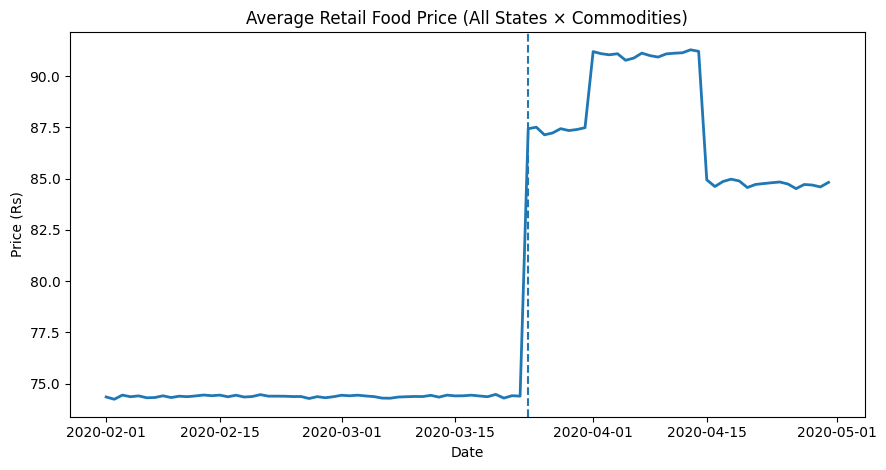

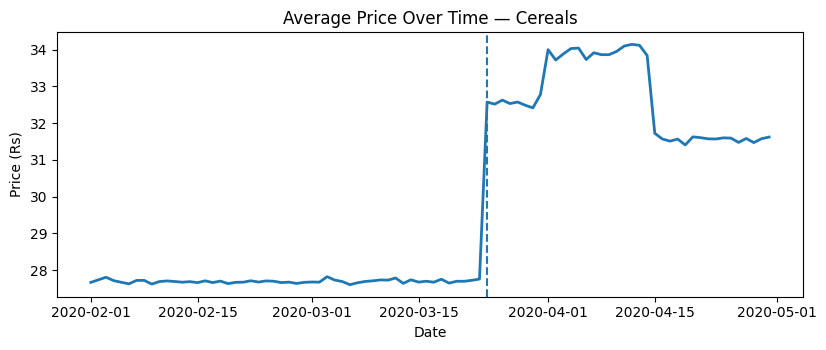

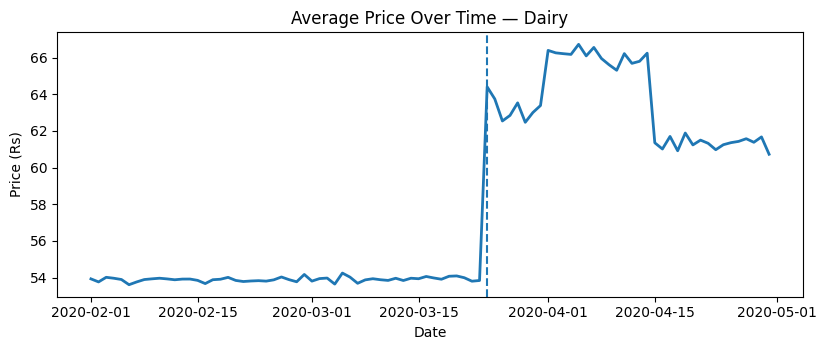

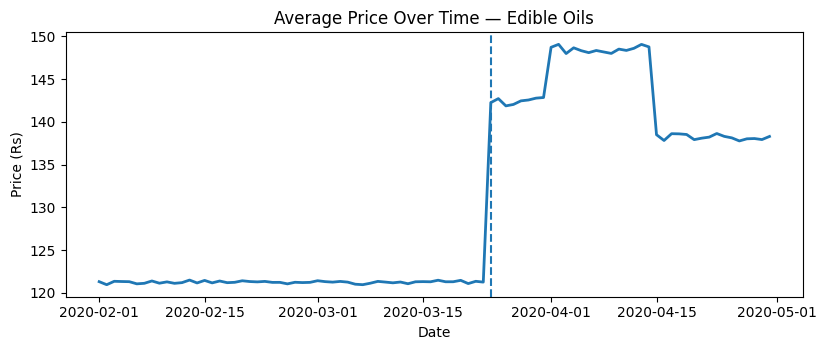

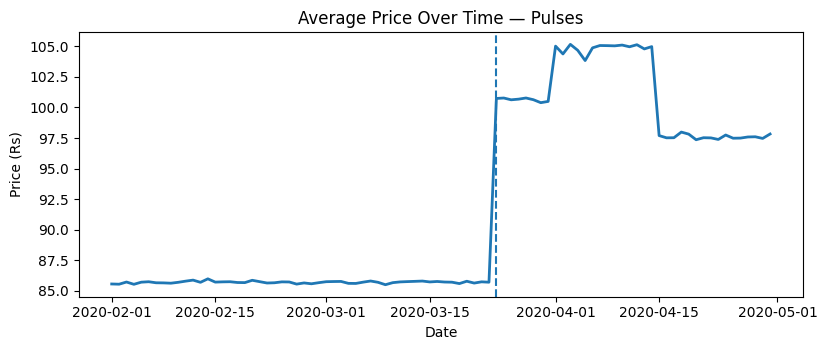

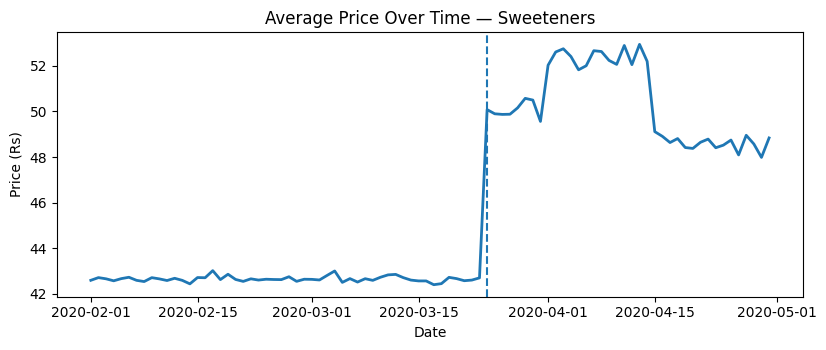

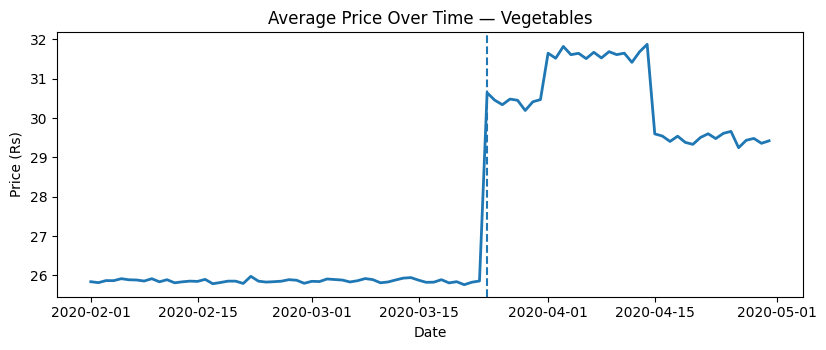

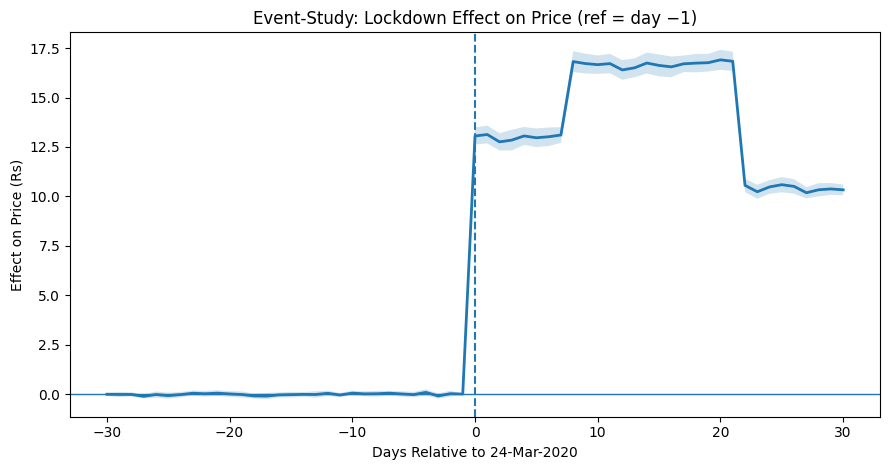

saved figures:
  figures/overall_avg_price.png
  figures/category_trend_<Category>.png  (multiple files)
  figures/event_study_lockdown.png


In [3]:
# %% [markdown]
# Visual evidence for the lockdown effect on food prices
# ------------------------------------------------------
# This cell assumes you already have a tidy DataFrame `df` with columns:
#   Date (or Date_dt), State, Commodity, Category, Price
# If `Date_dt` is missing, the code creates it from `Date`.
# Outputs:
#   figures/overall_avg_price.png
#   figures/category_trend_<Category>.png  (one per category)
#   figures/event_study_lockdown.png

# %% imports & setup
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# ---- 0) basic checks and light preprocessing
need = {"State", "Commodity", "Category", "Price"}
if "Date_dt" not in df.columns:
    if "Date" not in df.columns:
        raise ValueError("`df` must have either 'Date_dt' (datetime) or a parseable 'Date' column.")
    df = df.copy()
    df["Date_dt"] = pd.to_datetime(df["Date"], errors="raise")

missing = need - set(df.columns)
if missing:
    raise ValueError(f"`df` is missing columns: {sorted(missing)}")

lockdown_date = pd.to_datetime("2020-03-24")
os.makedirs("figures", exist_ok=True)

# A tiny helper to make safe filenames from category labels
def _safe(s: str) -> str:
    return re.sub(r"[^A-Za-z0-9_]+", "_", str(s)).strip("_")

# ---- 1) overall daily average (before vs after)
daily = df.groupby("Date_dt", as_index=False)["Price"].mean()

plt.figure(figsize=(9, 4.8))
plt.plot(daily["Date_dt"], daily["Price"], linewidth=2)
plt.axvline(lockdown_date, linestyle="--")
plt.title("Average Retail Food Price (All States × Commodities)")
plt.xlabel("Date"); plt.ylabel("Price (Rs)")
plt.tight_layout()
plt.savefig("figures/overall_avg_price.png", dpi=300)
plt.show()

# ---- 2) category-level trends (heterogeneity)
daily_cat = df.groupby(["Date_dt", "Category"], as_index=False)["Price"].mean()
for cat in sorted(daily_cat["Category"].unique()):
    sub = daily_cat[daily_cat["Category"] == cat]
    plt.figure(figsize=(8.4, 3.6))
    plt.plot(sub["Date_dt"], sub["Price"], linewidth=2)
    plt.axvline(lockdown_date, linestyle="--")
    plt.title(f"Average Price Over Time — {cat}")
    plt.xlabel("Date"); plt.ylabel("Price (Rs)")
    plt.tight_layout()
    plt.savefig(f"figures/category_trend_{_safe(cat)}.png", dpi=300)
    plt.show()

# ---- 3) event-study (leads/lags) with fixed effects and clustered SEs
# Core idea: encode days relative to lockdown as one categorical regressor,
# and set day -1 as the reference. This avoids illegal names like DD_-30.
dfe = df.copy()
dfe["rel_day"] = (dfe["Date_dt"] - lockdown_date).dt.days.astype(int)

# cap the window to keep the design compact
LAG, LEAD = 30, 30
dfe["rel_day_cap"] = dfe["rel_day"].clip(-LAG, LEAD).astype(int)

# treatment coding with reference = -1 (the day before lockdown)
formula = "Price ~ C(rel_day_cap, Treatment(reference=-1)) + C(State) + C(Commodity)"
event_mod = smf.ols(formula, data=dfe).fit(
    cov_type="cluster", cov_kwds={"groups": dfe["State"]}
)

# collect coefficients into a tidy frame
rows = []
for k in range(-LAG, LEAD + 1):
    if k == -1:
        rows.append({"rel_day": k, "coef": 0.0, "se": 0.0})
    else:
        name = f"C(rel_day_cap, Treatment(reference=-1))[T.{k}]"
        rows.append({
            "rel_day": k,
            "coef": float(event_mod.params.get(name, np.nan)),
            "se": float(event_mod.bse.get(name, np.nan))
        })

ev = pd.DataFrame(rows).dropna()
ev["lo"] = ev["coef"] - 1.96 * ev["se"]
ev["hi"] = ev["coef"] + 1.96 * ev["se"]

# plot the dynamic profile
plt.figure(figsize=(9, 4.8))
plt.axhline(0, linewidth=1)
plt.axvline(0, linestyle="--")
plt.plot(ev["rel_day"], ev["coef"], linewidth=2)
plt.fill_between(ev["rel_day"], ev["lo"], ev["hi"], alpha=0.2)
plt.title("Event-Study: Lockdown Effect on Price (ref = day −1)")
plt.xlabel("Days Relative to 24-Mar-2020"); plt.ylabel("Effect on Price (Rs)")
plt.tight_layout()
plt.savefig("figures/event_study_lockdown.png", dpi=300)
plt.show()

print("saved figures:")
print("  figures/overall_avg_price.png")
print("  figures/category_trend_<Category>.png  (multiple files)")
print("  figures/event_study_lockdown.png")


✅ Step 4 regression tables → /Users/nihao/outputs/step4_perishables.xlsx


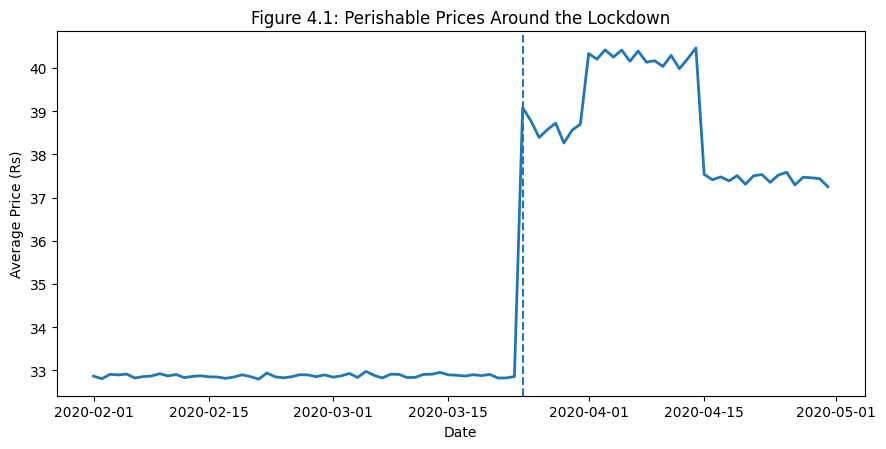

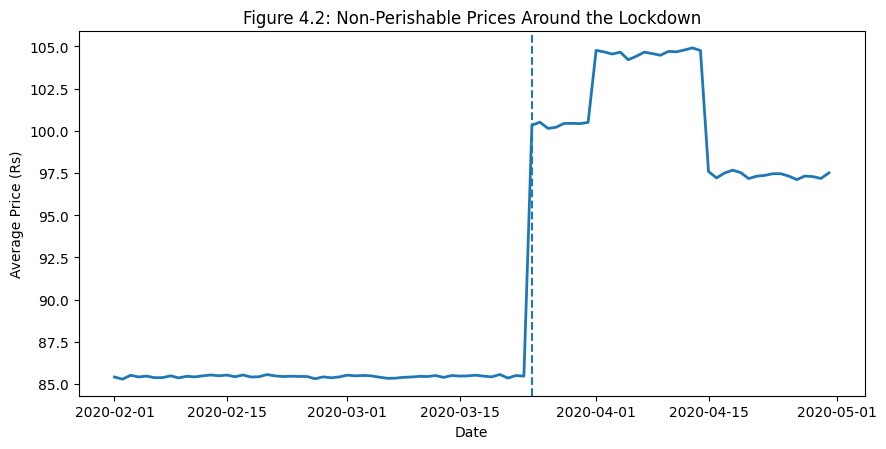

📁 Saved figures:
    /Users/nihao/figures/figure_4_1_perishable.png
    /Users/nihao/figures/figure_4_2_nonperishable.png

— Summary (PostLockdown coefficients) —
Perishables:      6.6923  (p=0.0000)
Non-Perishables:  17.3395  (p=0.0000)
Difference via interaction (PostLockdown:Perishable): -9.3811  (p=0.0000)


In [5]:
# %% [markdown]
# Step 4 — Heterogeneous Effects: Perishables vs Non-Perishables
# --------------------------------------------------------------
# What this cell does:
# 1) Create a Perishable indicator (robust to either Storage_Type or Category).
# 2) Estimate per-group regressions:
#       Price ~ PostLockdown + time_index + State FE   (SEs clustered by State)
#    separately for Perishables and Non-Perishables.
# 3) Run an interaction model to directly test the difference.
# 4) Export regression tables to Excel.
# 5) Plot and save Figure 4.1 (Perishables) and Figure 4.2 (Non-Perishables).

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# -------------------------------
# 0) Light checks / setup
# -------------------------------
need = {"Date_dt", "State", "Commodity", "Category", "Price"}
missing = need - set(df.columns)
if missing:
    raise ValueError(f"`df` is missing required columns: {sorted(missing)}")

lockdown_dt = pd.to_datetime("2020-03-24")

df4 = df.copy()
if "PostLockdown" not in df4.columns:
    df4["PostLockdown"] = (pd.to_datetime(df4["Date_dt"]) >= lockdown_dt).astype(int)
if "time_index" not in df4.columns:
    df4["time_index"] = (pd.to_datetime(df4["Date_dt"]) - pd.to_datetime(df4["Date_dt"]).min()).dt.days

os.makedirs("outputs", exist_ok=True)
os.makedirs("figures", exist_ok=True)

# -----------------------------------------
# 1) Perishable indicator (robust builder)
# -----------------------------------------
if "Storage_Type" in df4.columns:
    df4["Perishable"] = (df4["Storage_Type"].str.lower() == "perishable").astype(int)
else:
    # Adjust this mapping if your category names differ
    perishable_cats = {"Vegetables", "Fruits", "Dairy"}
    df4["Perishable"] = df4["Category"].apply(lambda x: 1 if str(x) in perishable_cats else 0)

# -----------------------------------------
# 2) Group-specific regressions
# -----------------------------------------
def run_group_reg(data, label):
    res = smf.ols(
        "Price ~ PostLockdown + time_index + C(State)",
        data=data
    ).fit(cov_type="cluster", cov_kwds={"groups": data["State"]})
    table = pd.DataFrame({
        "Variable": ["PostLockdown", "time_index", "Observations", "R-squared"],
        "Estimate": [
            res.params.get("PostLockdown", np.nan),
            res.params.get("time_index", np.nan),
            int(res.nobs),
            res.rsquared
        ],
        "Std. Error": [
            res.bse.get("PostLockdown", np.nan),
            res.bse.get("time_index", np.nan),
            np.nan, np.nan
        ],
        "p-value": [
            res.pvalues.get("PostLockdown", np.nan),
            res.pvalues.get("time_index", np.nan),
            np.nan, np.nan
        ],
        "Group": label
    })
    return res, table

perish_data = df4[df4["Perishable"] == 1]
nonper_data = df4[df4["Perishable"] == 0]

res_per, tab_per = run_group_reg(perish_data, "Perishable")
res_non, tab_non = run_group_reg(nonper_data, "Non-Perishable")

# -----------------------------------------
# 3) Direct test via interaction model
# -----------------------------------------
# Price ~ PostLockdown * Perishable + time_index + State FE
res_inter = smf.ols(
    "Price ~ PostLockdown * Perishable + time_index + C(State)",
    data=df4
).fit(cov_type="cluster", cov_kwds={"groups": df4["State"]})

inter_table = pd.DataFrame({
    "Variable": ["PostLockdown", "Perishable", "PostLockdown:Perishable", "time_index", "Observations", "R-squared"],
    "Estimate": [
        res_inter.params.get("PostLockdown", np.nan),
        res_inter.params.get("Perishable", np.nan),
        res_inter.params.get("PostLockdown:Perishable", np.nan),
        res_inter.params.get("time_index", np.nan),
        int(res_inter.nobs),
        res_inter.rsquared
    ],
    "Std. Error": [
        res_inter.bse.get("PostLockdown", np.nan),
        res_inter.bse.get("Perishable", np.nan),
        res_inter.bse.get("PostLockdown:Perishable", np.nan),
        res_inter.bse.get("time_index", np.nan),
        np.nan, np.nan
    ],
    "p-value": [
        res_inter.pvalues.get("PostLockdown", np.nan),
        res_inter.pvalues.get("Perishable", np.nan),
        res_inter.pvalues.get("PostLockdown:Perishable", np.nan),
        res_inter.pvalues.get("time_index", np.nan),
        np.nan, np.nan
    ],
})

# -----------------------------------------
# 4) Export regression tables to Excel
# -----------------------------------------
out_xlsx = "outputs/step4_perishables.xlsx"
with pd.ExcelWriter(out_xlsx, engine="openpyxl") as writer:
    tab_per.to_excel(writer, index=False, sheet_name="Perishable_only")
    tab_non.to_excel(writer, index=False, sheet_name="NonPerishable_only")
    inter_table.to_excel(writer, index=False, sheet_name="Interaction_test")

print(f"✅ Step 4 regression tables → {os.path.abspath(out_xlsx)}")

# -----------------------------------------
# 5) Plots: Figure 4.1 and Figure 4.2
# -----------------------------------------
# Figure 4.1 — Perishable prices around the lockdown
daily_per = perish_data.groupby("Date_dt", as_index=False)["Price"].mean()
plt.figure(figsize=(9,4.6))
plt.plot(daily_per["Date_dt"], daily_per["Price"], linewidth=2)
plt.axvline(lockdown_dt, linestyle="--")
plt.title("Figure 4.1: Perishable Prices Around the Lockdown")
plt.xlabel("Date"); plt.ylabel("Average Price (Rs)")
plt.tight_layout()
fig41_path = "figures/figure_4_1_perishable.png"
plt.savefig(fig41_path, dpi=300)
plt.show()

# Figure 4.2 — Non-Perishable prices around the lockdown
daily_non = nonper_data.groupby("Date_dt", as_index=False)["Price"].mean()
plt.figure(figsize=(9,4.6))
plt.plot(daily_non["Date_dt"], daily_non["Price"], linewidth=2)
plt.axvline(lockdown_dt, linestyle="--")
plt.title("Figure 4.2: Non-Perishable Prices Around the Lockdown")
plt.xlabel("Date"); plt.ylabel("Average Price (Rs)")
plt.tight_layout()
fig42_path = "figures/figure_4_2_nonperishable.png"
plt.savefig(fig42_path, dpi=300)
plt.show()

print("📁 Saved figures:")
print("   ", os.path.abspath(fig41_path))
print("   ", os.path.abspath(fig42_path))

# -----------------------------------------
# 6) Brief console summary (for your notes)
# -----------------------------------------
print("\n— Summary (PostLockdown coefficients) —")
print(f"Perishables:     {res_per.params.get('PostLockdown', np.nan): .4f}  (p={res_per.pvalues.get('PostLockdown', np.nan):.4f})")
print(f"Non-Perishables: {res_non.params.get('PostLockdown', np.nan): .4f}  (p={res_non.pvalues.get('PostLockdown', np.nan):.4f})")
print(f"Difference via interaction (PostLockdown:Perishable): {res_inter.params.get('PostLockdown:Perishable', np.nan): .4f}  (p={res_inter.pvalues.get('PostLockdown:Perishable', np.nan):.4f})")
